In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import numpy as np

import data_augmentation
import unet_model
import discriminator_model
import hyperparameters

import os
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [5]:
PATH = "/content/drive/My Drive/Datasets/Segmentation/CamVid/"

TRAIN_IMG_PATH = PATH + "train"
TRAIN_MSK_PATH = PATH + "train_mask"
VAL_IMG_PATH = PATH + "val"
VAL_MSK_PATH = PATH + "val_mask"
TEST_IMG_PATH = PATH + "test"
TEST_MSK_PATH = PATH + "test_mask"


train_imgs = os.listdir(TRAIN_IMG_PATH)
mask_imgs = os.listdir(TRAIN_MSK_PATH)

validation_imgs = os.listdir(VAL_IMG_PATH)
validation_msks = os.listdir(VAL_MSK_PATH)

test_imgs = os.listdir(TEST_IMG_PATH)
test_msks = os.listdir(TEST_MSK_PATH)

In [6]:
def load_train_image(filename, augment=True):
  
    train_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_IMG_PATH + '/' + filename)), tf.float32)
    masked_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_MSK_PATH + '/' + filename)), tf.float32)

    train_img, masked_img = data_augmentation.resize(train_img, masked_img, hyperparameters.IMG_HEIGHT, 
                                                     hyperparameters.IMG_WIDTH)
    
    if augment:
        train_img, masked_img = data_augmentation.randomizer(train_img, masked_img)
      
    train_img, masked_img = data_augmentation.normalize(train_img, masked_img)
    
    return train_img, masked_img

def load_val_image(filename, augment=True):
  
    validation_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_IMG_PATH + '/' + filename)), tf.float32)
    validation_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_MSK_PATH + '/' + filename)), tf.float32)

    validation_imgs, validation_msks = data_augmentation.resize(validation_imgs, validation_msks, 
                                                                hyperparameters.IMG_HEIGHT, 
                                                                hyperparameters.IMG_WIDTH)
      
    validation_imgs, validation_msks = data_augmentation.normalize(validation_imgs, validation_msks)
    
    return validation_imgs, validation_msks

def load_test_image(filename):
  
    test_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_IMG_PATH + '/' + filename)), tf.float32)
    test_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_MSK_PATH + '/' + filename)), tf.float32)

    test_imgs, test_msks = data_augmentation.resize(test_imgs, test_msks, 
                                                    hyperparameters.IMG_HEIGHT, 
                                                    hyperparameters.IMG_WIDTH)
      
    test_imgs, test_msks = data_augmentation.normalize(test_imgs, test_msks)
    
    return test_imgs, test_msks

def load_train_img(filename):
    return load_train_image(filename, True)

def load_validation_img(filename):
    return load_val_image(filename)

def load_test_img(filename):
    return load_test_image(filename)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = train_dataset.map(load_train_img)
train_dataset = train_dataset.shuffle(hyperparameters.BUFFER_SIZE)
train_dataset = train_dataset.batch(hyperparameters.BATCH_SIZE)

In [8]:
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_imgs)
validation_dataset = validation_dataset.map(load_validation_img)
validation_dataset = validation_dataset.batch(hyperparameters.BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)
test_dataset = test_dataset.map(load_test_img)
test_dataset = test_dataset.batch(hyperparameters.BATCH_SIZE)

In [9]:
unet_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator = unet_model.Unet_Generator()
discriminator = discriminator_model.Discriminator()

In [10]:
checkpoint_dir = PATH + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(unet_opt=unet_opt,
                                 discriminator_opt=discriminator_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def dice_coef(y_true, y_pred):
    smooth = 1e-5
    y_true = y_true * 0.5 + 0.5
    y_pred = y_pred * 0.5 + 0.5

    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [ ]:
# log_dir="logs/"

# summary_writer = tf.summary.create_file_writer(
#     log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [12]:
@tf.function
def gradients(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = unet_model.generator_loss(disc_generated_output, 
                                                                              gen_output, target)
        disc_loss = discriminator_model.discriminator_loss(disc_real_output, disc_generated_output)

    unet_gradients = gen_tape.gradient(gen_total_loss,
                                       generator.trainable_variables)
    discriminator_grads = disc_tape.gradient(disc_loss,
                                             discriminator.trainable_variables)

    unet_opt.apply_gradients(zip(unet_gradients,
                                 generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(discriminator_grads,
                                          discriminator.trainable_variables))

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    #     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    #     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    #     tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [13]:

def fit(train_data, epochs, test_data):

    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)

        for example_input, example_target in test_data.take(1):
            generate_images(generator, example_input, example_target)
            prediction = generator(example_input, training=True)
        print("Epoch: {}   Dice Coeficient: {}".format(epoch, dice_coef(tf.squeeze(example_target[0]), 
                                                                        tf.squeeze(prediction[0]))))

        for n, (input_image, target) in train_data.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            gradients(input_image, target, epoch)
        print()

        if (epoch + 1) % hyperparameters.CHK_EPOCH == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

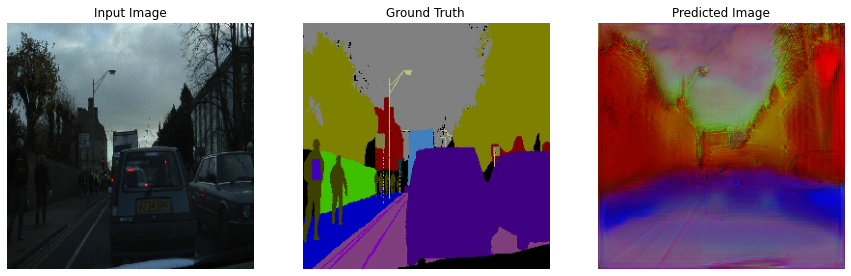

Epoch: 2   Dice Coeficient: 0.3868039846420288
................................

KeyboardInterrupt: ignored

In [14]:
fit(train_dataset, hyperparameters.EPOCHS, validation_dataset)

In [ ]:
for input, target in test_dataset.take(5):
  generate_images(generator, input, target)

In [24]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0, reduction="auto", 
                                         name="binary_crossentropy")
generator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=bce, metrics=[dice_coef])
generator.fit(train_dataset, batch_size=50, epochs=300, validation_batch_size=5,
              validation_data=val_dataset, verbose=1)

Epoch 1/300
1/1 - 119s - loss: -5.8392e+00 - dice_coef: 0.2078 - val_loss: -4.0142e+00 - val_dice_coef: 0.0306
Epoch 2/300
1/1 - 118s - loss: -5.5229e+00 - dice_coef: 0.1783 - val_loss: -3.9743e+00 - val_dice_coef: 0.0530
Epoch 3/300
1/1 - 118s - loss: -5.5989e+00 - dice_coef: 0.1929 - val_loss: -3.9475e+00 - val_dice_coef: 0.0515
Epoch 4/300


KeyboardInterrupt: ignored

In [ ]:
def show_predictions(dataset, num=1):

    for image, mask in dataset.take(num):

        pred_mask = generator.predict(image)
        plt.figure(figsize=(15,15))

        display_list = [image[0], mask[0], pred_mask[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):

            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')

        plt.show()

In [ ]:
show_predictions(test_dataset, 3)